In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import pickle

In [2]:
def reduce_mem_usage(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [3]:
data=pd.read_pickle('/notebooks/final_data.pkl').pipe(reduce_mem_usage)
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,lag_21,lag_28,lag_30,lag_45,lag_60,lag_80,expanding_sold_mean,daily_avg_sold,avg_sold,selling_trend
6098000,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1501,0,2015-03-09,11506,...,0.0,0.0,2.0,0.0,2.0,0.0,0.646973,0.0,0.669434,-0.669434
6098001,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1501,1,2015-03-09,11506,...,0.0,0.0,0.0,0.0,0.0,1.0,0.318359,1.0,0.304932,0.695312


In [4]:
from tqdm import tqdm
for col in tqdm(['id','item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','event_type_2','event_name_2','weekday']):
    data[col] = data[col].astype('category')

100%|██████████| 11/11 [00:00<00:00, 42.36it/s]


In [5]:
d_id = dict(zip(data.id.cat.codes, data.id))
d_item_id = dict(zip(data.item_id.cat.codes, data.item_id))
d_dept_id = dict(zip(data.dept_id.cat.codes, data.dept_id))
d_cat_id = dict(zip(data.cat_id.cat.codes, data.cat_id))
d_store_id = dict(zip(data.store_id.cat.codes, data.store_id))
d_state_id = dict(zip(data.state_id.cat.codes, data.state_id))

In [6]:
cols = data.dtypes.index.tolist()
d_types = data.dtypes.values.tolist()
for i,type in enumerate(d_types):
    if type.name == 'category':
        data[cols[i]] = data[cols[i]].cat.codes

In [7]:
data.drop(['date'],axis=1,inplace=True)

In [8]:
!pwd

/notebooks


In [9]:
X_train, y_train = data[data['d']<1914].drop('demand',axis=1), data[data['d']<1914]['demand']
X_valid, y_valid = data[(data['d']>=1914) & (data['d']<1942)].drop('demand',axis=1), data[(data['d']>=1914) & (data['d']<1942)]['demand']
X_test = data[data['d']>=1942].drop('demand',axis=1)

In [10]:
def rmse(pred,value):
    return np.sqrt(((pred-value)**2).mean())

# LinearRegression

In [11]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression(n_jobs=-1)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_valid)
print("Rmse: {}".format(rmse(y_pred,y_valid)))


Rmse: 0.002641104394569993


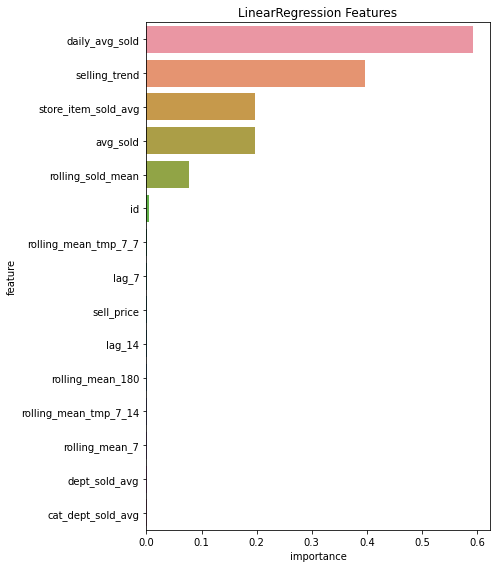

In [12]:
importance_df = pd.DataFrame()
importance_df["feature"] = X_train.columns
importance_df["importance"] = lr.coef_
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:15].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(7, 8))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LinearRegression Features')
    plt.tight_layout()
    
display_importances(importance_df)

# DecisionTree Regressor

In [13]:
from sklearn.tree import DecisionTreeRegressor
import random
for i in tqdm(range(10)): 
    max_depth=random.randint(1,200)
    min_samples_split=random.randint(10,600)
    min_samples_leaf=random.randint(20,500)
    dt=DecisionTreeRegressor(max_depth=max_depth,min_samples_split=min_samples_split,max_leaf_nodes=min_samples_leaf)
    dt.fit(X_train,y_train)
    y_pred=dt.predict(X_valid)
    print("\n\nmax_depth: {}".format(max_depth),"  min_samples_split: {}".format(min_samples_split),"  min_samples_leaf: {}".format(min_samples_leaf),"  Rmse: {}".format(rmse(y_pred,y_valid)))
    print("-"*100)

 10%|█         | 1/10 [03:19<29:58, 199.80s/it]



max_depth: 87   min_samples_split: 403   min_samples_leaf: 306   Rmse: 0.08088444572232606
----------------------------------------------------------------------------------------------------


 20%|██        | 2/10 [06:39<26:36, 199.54s/it]



max_depth: 106   min_samples_split: 280   min_samples_leaf: 64   Rmse: 0.06673395340572601
----------------------------------------------------------------------------------------------------


 30%|███       | 3/10 [09:59<23:20, 200.08s/it]



max_depth: 49   min_samples_split: 69   min_samples_leaf: 116   Rmse: 0.021527462557423008
----------------------------------------------------------------------------------------------------


 40%|████      | 4/10 [13:26<20:15, 202.52s/it]



max_depth: 79   min_samples_split: 159   min_samples_leaf: 335   Rmse: 0.05535995566632401
----------------------------------------------------------------------------------------------------


 50%|█████     | 5/10 [16:54<17:03, 204.64s/it]



max_depth: 128   min_samples_split: 183   min_samples_leaf: 442   Rmse: 0.055898457049682736
----------------------------------------------------------------------------------------------------


 60%|██████    | 6/10 [20:16<13:34, 203.69s/it]



max_depth: 106   min_samples_split: 353   min_samples_leaf: 497   Rmse: 0.06399247981236453
----------------------------------------------------------------------------------------------------


 70%|███████   | 7/10 [23:36<10:07, 202.67s/it]



max_depth: 48   min_samples_split: 288   min_samples_leaf: 178   Rmse: 0.06217046437677285
----------------------------------------------------------------------------------------------------


 80%|████████  | 8/10 [26:57<06:43, 201.97s/it]



max_depth: 132   min_samples_split: 504   min_samples_leaf: 265   Rmse: 0.10061099170111709
----------------------------------------------------------------------------------------------------


 90%|█████████ | 9/10 [30:17<03:21, 201.37s/it]



max_depth: 125   min_samples_split: 575   min_samples_leaf: 72   Rmse: 0.10333224378608999
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [33:40<00:00, 202.04s/it]



max_depth: 52   min_samples_split: 25   min_samples_leaf: 293   Rmse: 0.008081689548930113
----------------------------------------------------------------------------------------------------


In [15]:
max_depth=52
min_samples_split=25
min_samples_leaf=293
dt=DecisionTreeRegressor(max_depth=max_depth,min_samples_split=min_samples_split,max_leaf_nodes=min_samples_leaf)
dt.fit(X_train,y_train)
y_pred=dt.predict(X_valid)
print("max_depth: {}".format(max_depth),"  min_samples_split: {}".format(min_samples_split),"  min_samples_leaf: {}".format(min_samples_leaf),"Rmse: {}".format(rmse(y_pred,y_valid)))

max_depth: 52   min_samples_split: 25   min_samples_leaf: 293 Rmse: 0.008081689548930113


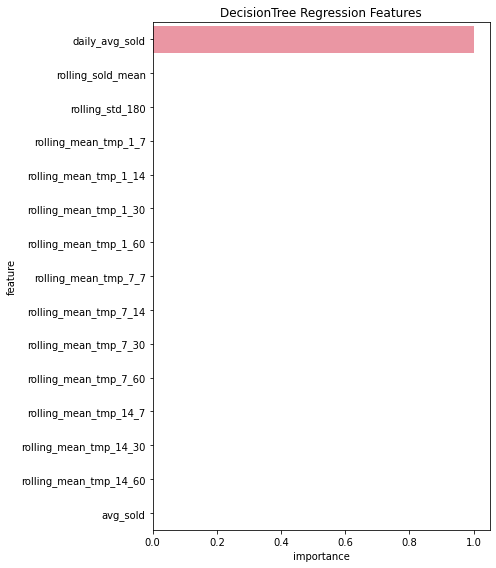

In [16]:
importance_df = pd.DataFrame()
importance_df["feature"] = X_train.columns
importance_df["importance"] = dt.feature_importances_
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:15].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(7, 8))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('DecisionTree Regression Features')
    plt.tight_layout()
    
display_importances(importance_df)

# LGBM Regressor

In [17]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.4 MB/s eta 0:00:00


In [19]:
from lightgbm import LGBMRegressor
for i in tqdm(range(15)):
    learning_rate=np.round(np.random.uniform(0.001,0.05),4)
    max_depth=np.random.randint(5,200)
    num_leaves=np.random.randint(20,300)
    lgb=LGBMRegressor(learning_rate=learning_rate,max_depth=max_depth,num_leaves=num_leaves,n_jobs=-1,n_estimators=100)
    lgb.fit(X_train,y_train)
    y_pred=lgb.predict(X_valid)
    print("\nlearning_rate: {}".format(learning_rate),"  max_depth: {}".format(max_depth),"  num_leaves: {}".format(num_leaves),"  Rmse: {}".format(rmse(y_pred,y_valid)))
    print("-"*120)

  7%|▋         | 1/15 [01:42<23:51, 102.25s/it]


learning_rate: 0.0359   max_depth: 47   num_leaves: 109   Rmse: 0.10496935417812837
------------------------------------------------------------------------------------------------------------------------


 13%|█▎        | 2/15 [03:20<21:39, 99.95s/it] 


learning_rate: 0.0045   max_depth: 90   num_leaves: 166   Rmse: 2.320816498893697
------------------------------------------------------------------------------------------------------------------------


 20%|██        | 3/15 [05:04<20:22, 101.86s/it]


learning_rate: 0.0445   max_depth: 114   num_leaves: 208   Rmse: 0.06239371051621268
------------------------------------------------------------------------------------------------------------------------


 27%|██▋       | 4/15 [06:44<18:32, 101.13s/it]


learning_rate: 0.0054   max_depth: 86   num_leaves: 175   Rmse: 2.120028254325059
------------------------------------------------------------------------------------------------------------------------


 33%|███▎      | 5/15 [08:17<16:22, 98.26s/it] 


learning_rate: 0.0249   max_depth: 7   num_leaves: 108   Rmse: 0.2949638015011531
------------------------------------------------------------------------------------------------------------------------


 40%|████      | 6/15 [09:57<14:48, 98.72s/it]


learning_rate: 0.0072   max_depth: 105   num_leaves: 93   Rmse: 1.7684486289501848
------------------------------------------------------------------------------------------------------------------------


 47%|████▋     | 7/15 [11:38<13:15, 99.40s/it]


learning_rate: 0.0147   max_depth: 31   num_leaves: 140   Rmse: 0.8281102644076813
------------------------------------------------------------------------------------------------------------------------


 53%|█████▎    | 8/15 [13:18<11:37, 99.65s/it]


learning_rate: 0.0035   max_depth: 97   num_leaves: 95   Rmse: 2.5659811921546782
------------------------------------------------------------------------------------------------------------------------


 60%|██████    | 9/15 [15:00<10:02, 100.47s/it]


learning_rate: 0.0256   max_depth: 81   num_leaves: 263   Rmse: 0.2744052307734476
------------------------------------------------------------------------------------------------------------------------


 67%|██████▋   | 10/15 [16:34<08:12, 98.50s/it]


learning_rate: 0.0187   max_depth: 24   num_leaves: 144   Rmse: 0.5517611982502039
------------------------------------------------------------------------------------------------------------------------


 73%|███████▎  | 11/15 [18:12<06:33, 98.31s/it]


learning_rate: 0.0178   max_depth: 13   num_leaves: 258   Rmse: 0.6043845195887448
------------------------------------------------------------------------------------------------------------------------


 80%|████████  | 12/15 [19:39<04:44, 94.91s/it]


learning_rate: 0.0355   max_depth: 135   num_leaves: 54   Rmse: 0.10806583939225903
------------------------------------------------------------------------------------------------------------------------


 87%|████████▋ | 13/15 [21:04<03:03, 91.71s/it]


learning_rate: 0.0076   max_depth: 140   num_leaves: 96   Rmse: 1.6984586745062944
------------------------------------------------------------------------------------------------------------------------


 93%|█████████▎| 14/15 [22:33<01:30, 90.91s/it]


learning_rate: 0.0207   max_depth: 19   num_leaves: 171   Rmse: 0.4503403186029524
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 15/15 [24:09<00:00, 96.67s/it]


learning_rate: 0.0233   max_depth: 180   num_leaves: 296   Rmse: 0.34589929734957064
------------------------------------------------------------------------------------------------------------------------


In [21]:
learning_rate=0.0355
max_depth=135
num_leaves=54
lgb=LGBMRegressor(learning_rate=learning_rate,max_depth=max_depth,num_leaves=num_leaves,n_jobs=-1,n_estimators=100)
lgb.fit(X_train,y_train)
y_pred=lgb.predict(X_valid)
print("learning_rate: {}".format(learning_rate),"  max_depth: {}".format(max_depth),"  num_leaves: {}".format(num_leaves),"  Rmse: {}".format(rmse(y_pred,y_valid)))

learning_rate: 0.0355   max_depth: 135   num_leaves: 54   Rmse: 0.10806583939225903


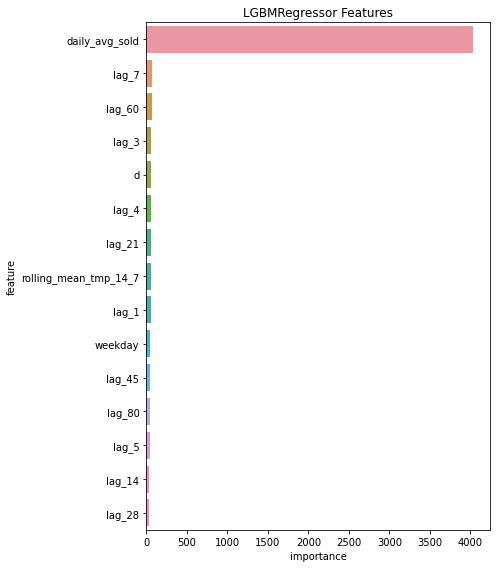

In [22]:
importance_df = pd.DataFrame()
importance_df["feature"] = X_train.columns
importance_df["importance"] = lgb.feature_importances_
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:15].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(7, 8))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LGBMRegressor Features')
    plt.tight_layout()
    
display_importances(importance_df)

# XGBoost Regressor

In [24]:
from xgboost import XGBRegressor
for i in tqdm(range(10)):
    #https://pynative.com/python-get-random-float-numbers
    learning_rate=np.round(np.random.uniform(0.001,0.05),4)
    max_leaves=np.random.randint(20,150)
    min_child_weight=random.randint(20,100) 
    xgb=XGBRegressor(learning_rate=learning_rate,max_leaves=max_leaves,min_child_weight=min_child_weight,subsample=0.7,colsample_bytree=0.7,tree_method='gpu_hist',gpu_id=0,grow_policy='lossguide',n_estimators=100,objective='reg:squarederror',booster='gbtree',n_jobs=-1)
    xgb.fit(X_train,y_train)
    y_pred=xgb.predict(X_valid)
    print("\nlearning_rate: {}".format(learning_rate),"  max_leaves: {}".format(max_leaves),"  min_child_weight: {}".format(min_child_weight),"  Rmse: {}".format(rmse(y_pred,y_valid)))
    print("-"*100) 

 10%|█         | 1/10 [00:39<05:58, 39.86s/it]


learning_rate: 0.0059   max_leaves: 77   min_child_weight: 81   Rmse: 2.1146366596221924
----------------------------------------------------------------------------------------------------


 20%|██        | 2/10 [01:18<05:15, 39.43s/it]


learning_rate: 0.0188   max_leaves: 62   min_child_weight: 65   Rmse: 0.6129684448242188
----------------------------------------------------------------------------------------------------


 30%|███       | 3/10 [01:57<04:33, 39.11s/it]


learning_rate: 0.0451   max_leaves: 80   min_child_weight: 36   Rmse: 0.16370414197444916
----------------------------------------------------------------------------------------------------


 40%|████      | 4/10 [02:38<03:57, 39.64s/it]


learning_rate: 0.0264   max_leaves: 79   min_child_weight: 85   Rmse: 0.3221835196018219
----------------------------------------------------------------------------------------------------


 50%|█████     | 5/10 [03:17<03:17, 39.42s/it]


learning_rate: 0.0258   max_leaves: 42   min_child_weight: 45   Rmse: 0.34355008602142334
----------------------------------------------------------------------------------------------------


 60%|██████    | 6/10 [03:54<02:34, 38.65s/it]


learning_rate: 0.0434   max_leaves: 25   min_child_weight: 83   Rmse: 0.18655599653720856
----------------------------------------------------------------------------------------------------


 70%|███████   | 7/10 [04:33<01:56, 38.69s/it]


learning_rate: 0.0312   max_leaves: 60   min_child_weight: 57   Rmse: 0.23670755326747894
----------------------------------------------------------------------------------------------------


 80%|████████  | 8/10 [05:11<01:17, 38.69s/it]


learning_rate: 0.008   max_leaves: 44   min_child_weight: 62   Rmse: 1.7252520322799683
----------------------------------------------------------------------------------------------------


 90%|█████████ | 9/10 [05:51<00:38, 38.89s/it]


learning_rate: 0.0157   max_leaves: 93   min_child_weight: 49   Rmse: 0.8190671801567078
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [06:31<00:00, 39.17s/it]


learning_rate: 0.0393   max_leaves: 83   min_child_weight: 92   Rmse: 0.18081003427505493
----------------------------------------------------------------------------------------------------


In [25]:
learning_rate=0.0451
max_leaves=80
min_child_weight=36
xgb=XGBRegressor(learning_rate=learning_rate,max_leaves=max_leaves,min_child_weight=min_child_weight,subsample=0.7,colsample_bytree=0.7,tree_method='gpu_hist',gpu_id=0,grow_policy='lossguide',n_estimators=100,objective='reg:squarederror',booster='gbtree',n_jobs=-1)
xgb.fit(X_train,y_train)
y_pred=xgb.predict(X_valid)
print("learning_rate: {}".format(learning_rate),"  max_leaves: {}".format(max_leaves),"  min_child_weight: {}".format(min_child_weight),"  Rmse: {}".format(rmse(y_pred,y_valid)))

learning_rate: 0.0451   max_leaves: 80   min_child_weight: 36   Rmse: 0.16370414197444916


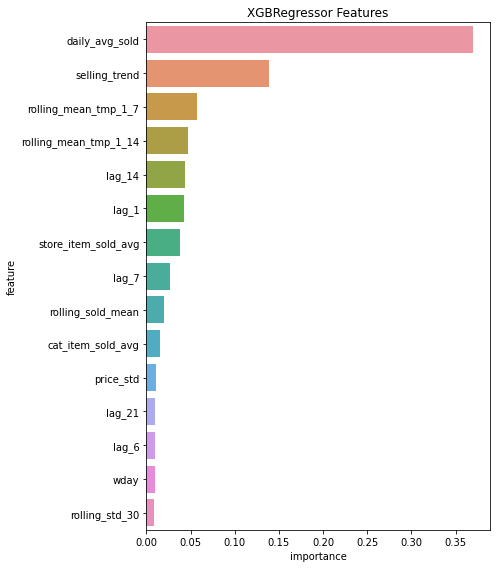

In [26]:
importance_df = pd.DataFrame()
importance_df["feature"] = X_train.columns
importance_df["importance"] = xgb.feature_importances_
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:15].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(7, 8))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGBRegressor Features')
    plt.tight_layout()
    
display_importances(importance_df)

# CatBoost Regressor

In [11]:
!pip install catboost

In [13]:
from catboost import CatBoostRegressor
for i in tqdm(range(5)):
    learning_rate=np.round(np.random.uniform(0.001,0.05),4)
    depth=np.random.randint(1,10)
    num_leaves=np.random.randint(20,200)
    #https://stackoverflow.com/questions/51111323/how-to-suppress-catboost-iteration-results
    cb=CatBoostRegressor(learning_rate=learning_rate,depth=depth,num_leaves=num_leaves,iterations=200,grow_policy='Lossguide',logging_level="Silent")
    cb.fit(X_train,y_train)
    y_pred=cb.predict(X_valid)
    print("\nlearning_rate: {}".format(learning_rate),"  depth: {}".format(depth),"  num_leaves: {}".format(num_leaves),"  Rmse: {}".format(rmse(y_pred,y_valid)))
    print("-"*100)

 20%|██        | 1/5 [05:43<22:52, 343.18s/it]


learning_rate: 0.0134   depth: 1   num_leaves: 97   Rmse: 1.3110875420336086
----------------------------------------------------------------------------------------------------


 40%|████      | 2/5 [13:50<21:24, 428.06s/it]


learning_rate: 0.012   depth: 2   num_leaves: 131   Rmse: 0.5644172930792731
----------------------------------------------------------------------------------------------------


 60%|██████    | 3/5 [26:59<19:45, 592.62s/it]


learning_rate: 0.0444   depth: 4   num_leaves: 41   Rmse: 0.04841095114517876
----------------------------------------------------------------------------------------------------


 80%|████████  | 4/5 [46:35<13:43, 823.25s/it]


learning_rate: 0.0054   depth: 6   num_leaves: 169   Rmse: 1.2414971300326965
----------------------------------------------------------------------------------------------------


100%|██████████| 5/5 [52:05<00:00, 625.07s/it]


learning_rate: 0.0413   depth: 1   num_leaves: 183   Rmse: 0.2586696801928805
----------------------------------------------------------------------------------------------------


In [14]:
from catboost import CatBoostRegressor
learning_rate=0.0291
depth=4
num_leaves=199
cb=CatBoostRegressor(learning_rate=learning_rate,depth=depth,num_leaves=num_leaves,iterations=200,grow_policy='Lossguide',logging_level="Silent")
cb.fit(X_train,y_train)
y_pred=cb.predict(X_valid)
print("learning_rate: {}".format(learning_rate),"  depth: {}".format(depth),"  num_leaves: {}".format(num_leaves),"  Rmse: {}".format(rmse(y_pred,y_valid)))

learning_rate: 0.0291   depth: 4   num_leaves: 199   Rmse: 0.0471199603834599


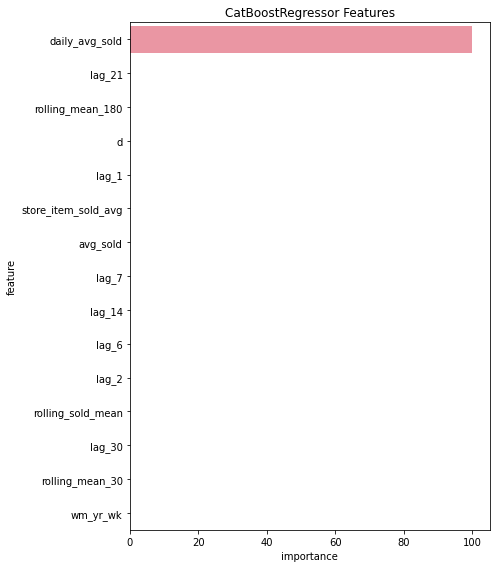

In [15]:
importance_df = pd.DataFrame()
importance_df["feature"] = X_train.columns
importance_df["importance"] = cb.feature_importances_
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:15].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(7, 8))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('CatBoostRegressor Features')
    plt.tight_layout()
    
display_importances(importance_df)